In [32]:
%matplotlib inline

import os
import numpy as np
from analysis.models.vr import RatCAVESession
from analysis.models.spiking import unit_data
from analysis.plots.placecells import unit_place_firing_with_autocorr, unit_place_firing_aBc


# expect: elongated fields, fields overlap, cut-out fields

# interesting sessions for 002430
s_002430 = [
    "2019-02-27_13-21-54"  # 6-3, 6-7 lock to arena, lock to a-B border
]


# interesting sessions for 002431
s_002431 = [
    "2019-02-26_10-30-36",  # poor data
    "2019-02-22_15-28-51",  # 6-4 cell maybe
    "2019-02-21_22-27-31",  # poor data
    "2019-02-21_15-28-18"   # poor data
]

In [33]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [34]:
source = '/home/andrey/storage2/andrey/data/processed'
animal = '002431'
session_id = "2019-02-22_15-28-51"

sessionpath = os.path.join(source, animal, session_id)

session = RatCAVESession(sessionpath, alpha=4.3)
running_idxs = session.get_running_indexes()[0]

# Overview

In [35]:
session.tetrode_unit_map

{1: [2, 3, 4], 2: [2, 3], 3: [], 4: [], 5: [], 6: [2, 3, 4, 5], 7: [], 8: []}

In [36]:
# fetching positions and autocorrs
all_pos = session.trajectory[:, 1:3]
unit_pos_dict = session.get_unit_positions_with_autocorrs(running_idxs)

Completed.


In [37]:
# drawing small plots
fig = unit_place_firing_with_autocorr(all_pos, unit_pos_dict, per_row=4)

filename = "unit_firing_maps_with_autocorr.png"
fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

Processing unit group 6..

# Place fields in RW and VR coordinates

TTD 6 Unit 5 completed

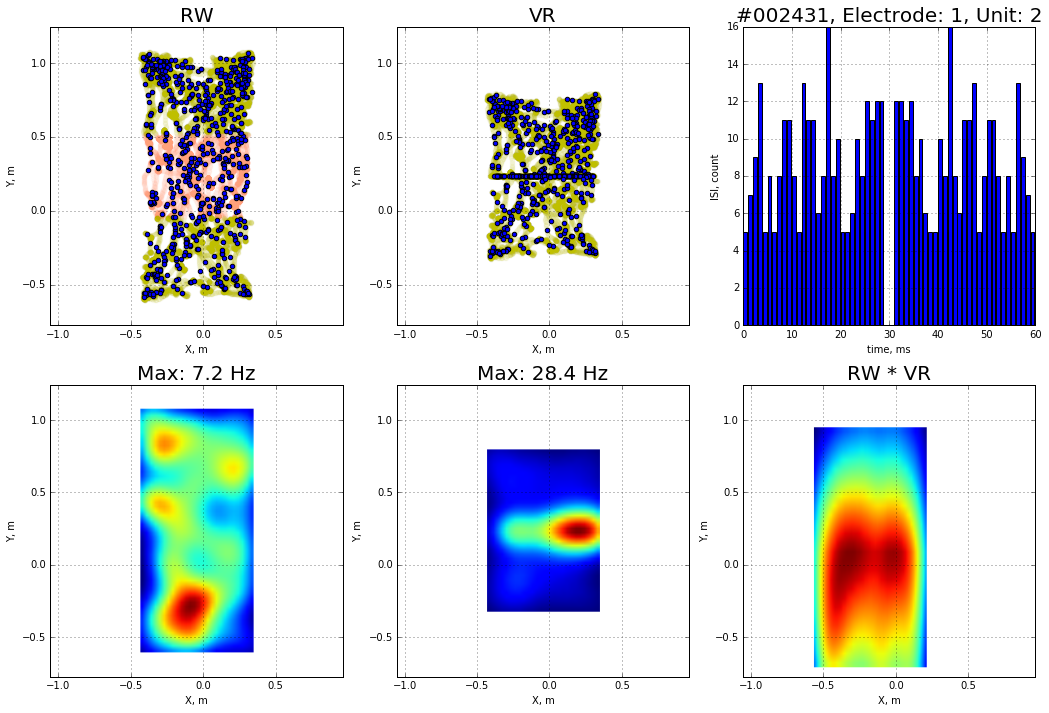

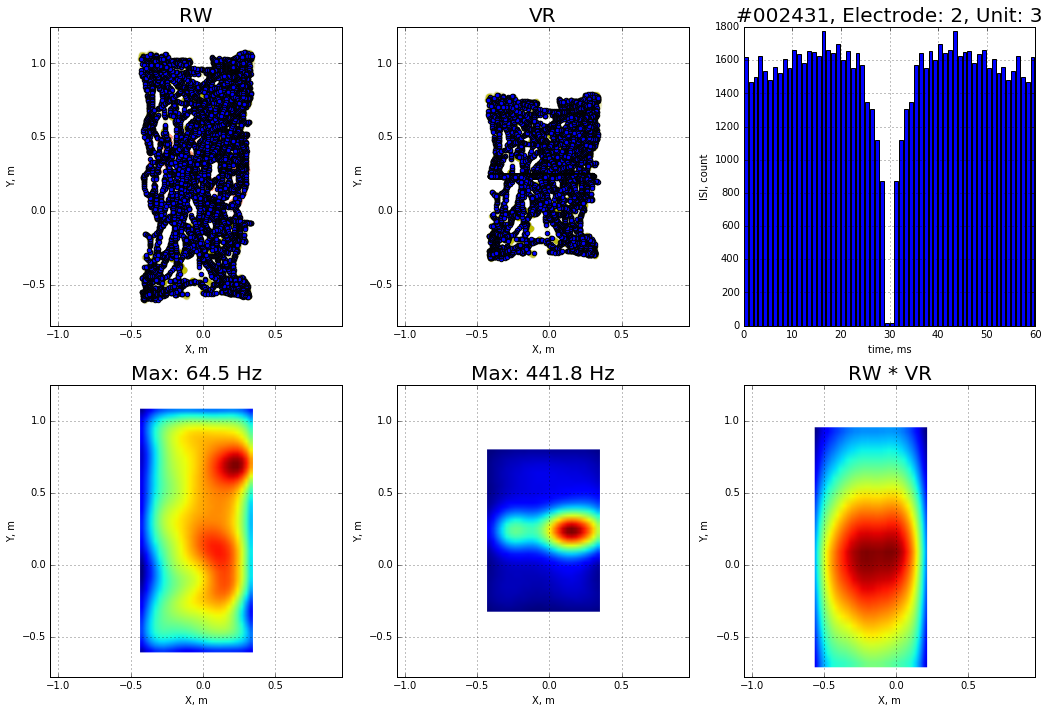

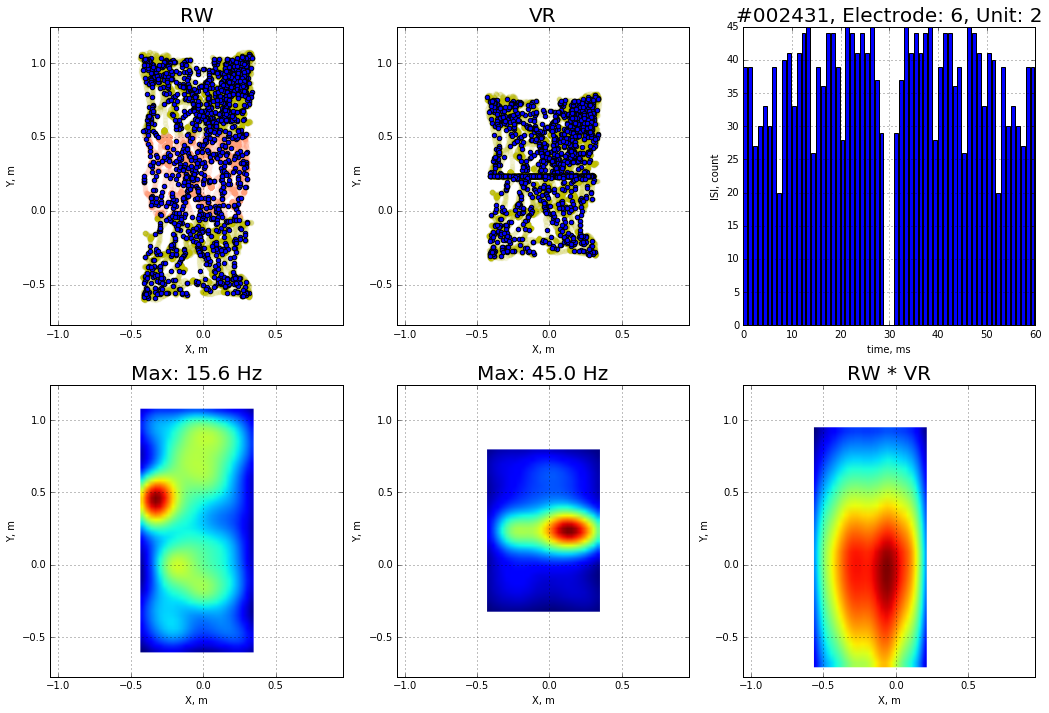

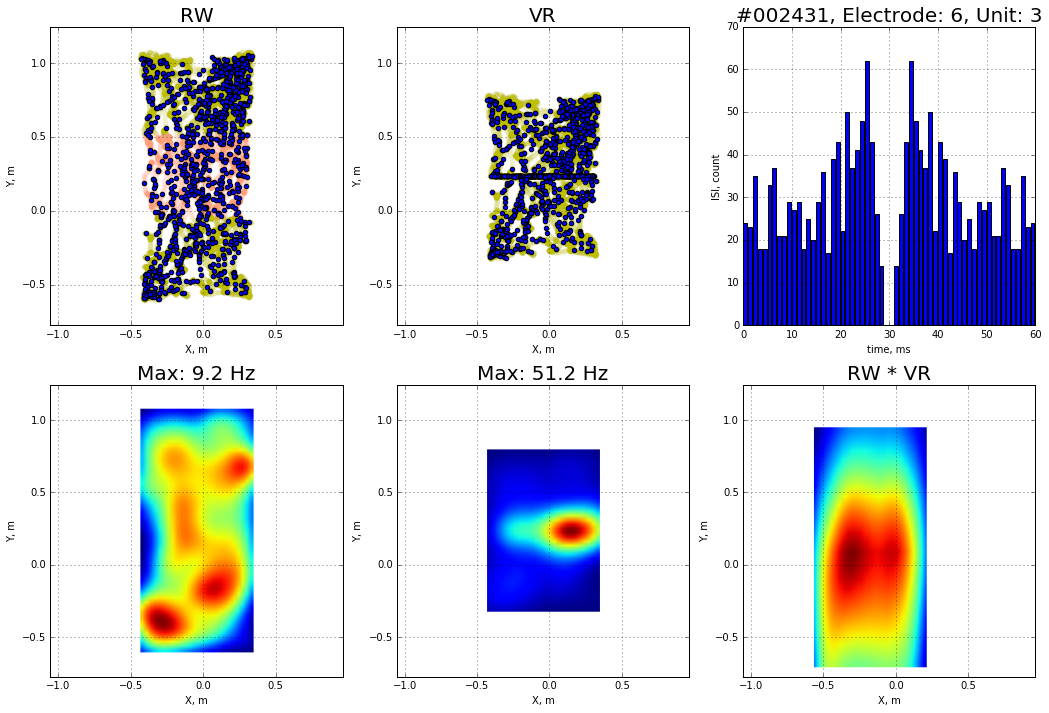

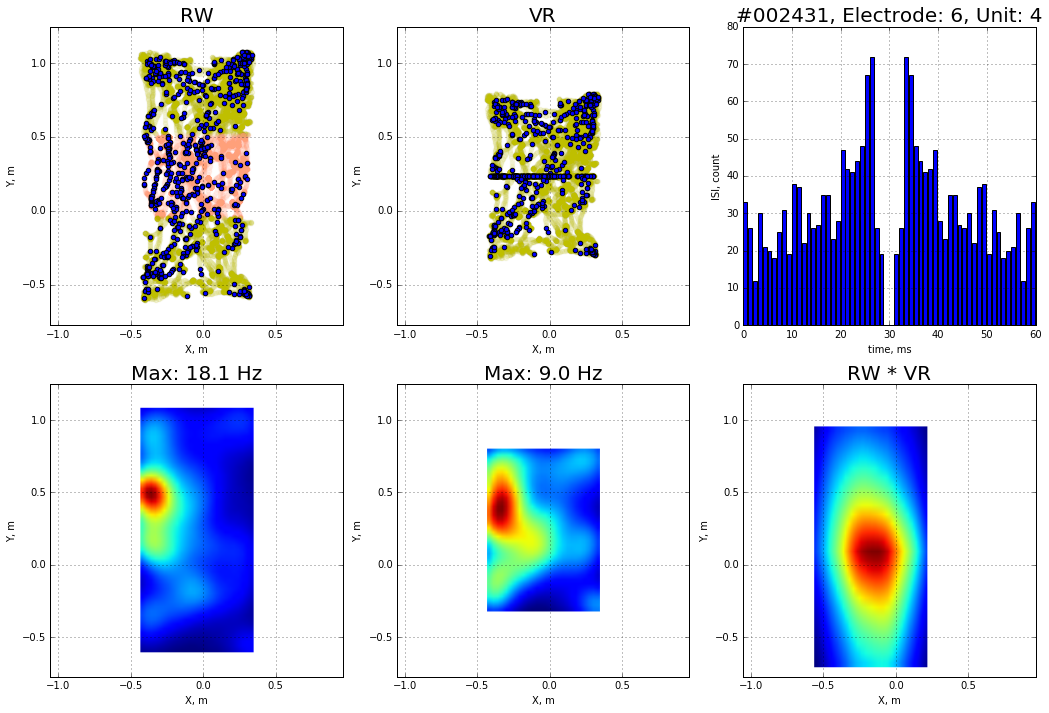

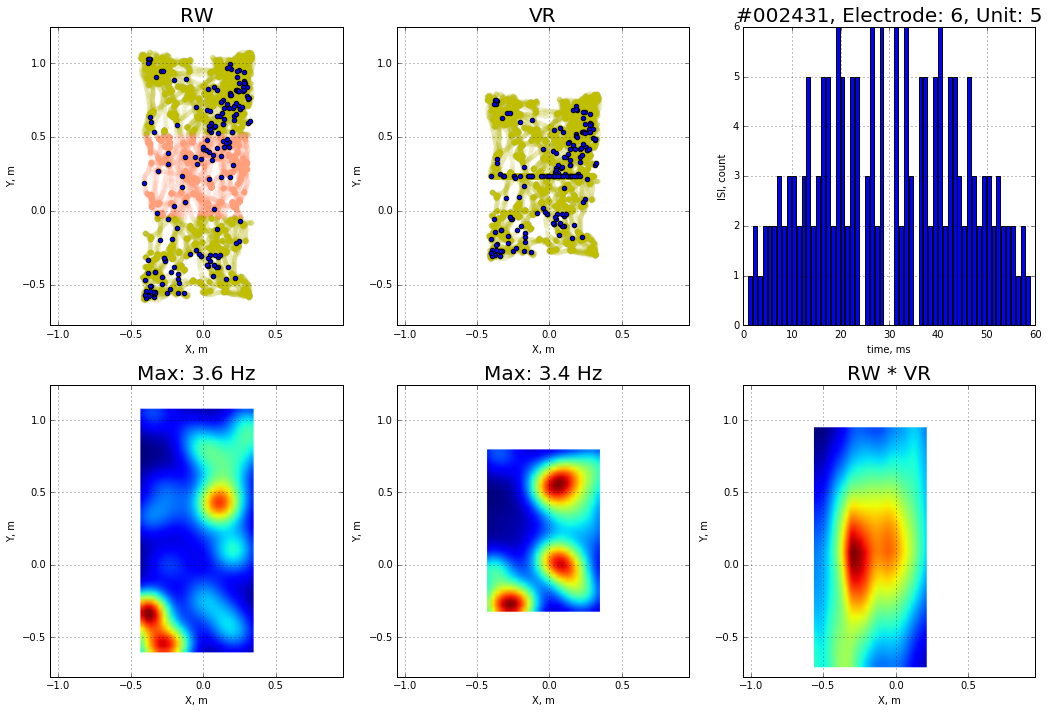

In [38]:
from analysis.plots.placecells import draw_place_field, draw_place_firing, draw_autocorrelogram
from analysis.plots.placecells import get_figure_size, get_extent
from analysis.models.analytics import place_field_2D
from matplotlib.pyplot import figure
from scipy.signal import correlate2d

sampling_rate = 50

for ttd, units in session.tetrode_unit_map.items():
    for unit in units:
        fig = figure(figsize=(3 * 5, 2 * 5))

        limits = get_figure_size(session.trajectory[:, 1:3])

        trajectory = session.trajectory
        unit_fire = session.get_positions_for_unit(ttd, unit, running_idxs)[:, 1:3]
        spiket = session.get_unit_firing_at_freq(ttd, unit, sampling_rate)
        pos_at_f = session.get_positions_at_freq(sampling_rate)


        # spiking in RW
        all_pos = trajectory[:, 1:3]

        y_min = np.min(all_pos[:, 1])
        y_max = np.max(all_pos[:, 1])
        y_delta = np.abs(y_min - y_max)

        all_pos_a = all_pos[(all_pos[:, 1] > y_max - y_delta / 3)]
        all_pos_B = all_pos[(all_pos[:, 1] < y_max - y_delta / 3) & (all_pos[:, 1] > y_min + y_delta / 3)]
        all_pos_c = all_pos[(all_pos[:, 1] < y_min + y_delta / 3)]

        unit_pos_a = unit_fire[(unit_fire[:, 1] > y_max - y_delta / 3)]
        unit_pos_B = unit_fire[(unit_fire[:, 1] < y_max - y_delta / 3) & (unit_fire[:, 1] > y_min + y_delta / 3)]
        unit_pos_c = unit_fire[(unit_fire[:, 1] < y_min + y_delta / 3)]

        ax_1 = fig.add_subplot(2, 3, 1)
        ax_1.scatter(all_pos_a[:, 0], all_pos_a[:, 1], alpha=0.05, color='y')
        ax_1.scatter(all_pos_B[:, 0], all_pos_B[:, 1], alpha=0.05, color='lightsalmon')
        ax_1.scatter(all_pos_c[:, 0], all_pos_c[:, 1], alpha=0.05, color='y')
        ax_1.scatter(unit_fire[:, 0], unit_fire[:, 1])
        ax_1.set_title('RW', fontsize=20)
        ax_1.set_xlabel('X, m')
        ax_1.set_ylabel('Y, m')
        ax_1.grid(True)
        ax_1.set_xlim(limits[0], limits[1])
        ax_1.set_ylim(limits[2], limits[3])


        # place field in RW
        omap, smap, fmap, s_f_map_RW = place_field_2D(pos_at_f, spiket, sampling_rate, 0.03)
        extent_RW = get_extent(pos_at_f)

        ax_4 = fig.add_subplot(2, 3, 4)
        ax_4.set_title("Max: %2.1f Hz" % (s_f_map_RW.max()), fontsize=20)
        draw_place_field(ax_4, s_f_map_RW, limits, extent_RW)


        # spiking in VR
        all_pos_a_2 = np.array([(x[0], x[1] - y_delta / 6) for x in all_pos_a])
        all_pos_B_2 = np.array([(x[0], y_max - y_delta / 2) for x in all_pos_B])
        all_pos_c_2 = np.array([(x[0], x[1] + y_delta / 6) for x in all_pos_c])

        unit_pos_a_2 = np.array([(x[0], x[1] - y_delta / 6) for x in unit_pos_a])
        unit_pos_B_2 = np.array([(x[0], y_max - y_delta / 2) for x in unit_pos_B])
        unit_pos_c_2 = np.array([(x[0], x[1] + y_delta / 6) for x in unit_pos_c])

        ax_2 = fig.add_subplot(2, 3, 2)
        ax_2.scatter(all_pos_a_2[:, 0], all_pos_a_2[:, 1], alpha=0.05, color='y')
        ax_2.scatter(all_pos_B_2[:, 0], all_pos_B_2[:, 1], alpha=0.05, color='y')
        ax_2.scatter(all_pos_c_2[:, 0], all_pos_c_2[:, 1], alpha=0.05, color='y')
        ax_2.scatter(unit_pos_a_2[:, 0], unit_pos_a_2[:, 1])
        ax_2.scatter(unit_pos_B_2[:, 0], unit_pos_B_2[:, 1])
        ax_2.scatter(unit_pos_c_2[:, 0], unit_pos_c_2[:, 1])
        ax_2.set_title('VR', fontsize=20)
        ax_2.set_xlabel('X, m')
        ax_2.set_ylabel('Y, m')
        ax_2.grid(True)
        ax_2.set_xlim(limits[0], limits[1])
        ax_2.set_ylim(limits[2], limits[3])


        # place field in VR
        pos_shrinked = np.array(pos_at_f)
        pos_shrinked[(pos_at_f[:, 1] > y_max - y_delta / 3), 1] -= y_delta / 6
        pos_shrinked[(pos_at_f[:, 1] > y_min + y_delta / 3) & (pos_at_f[:, 1] < y_max - y_delta / 3), 1] = y_max - y_delta / 2
        pos_shrinked[(pos_at_f[:, 1] < y_min + y_delta / 3), 1] += y_delta / 6

        omap, smap, fmap, s_f_map_VR = place_field_2D(pos_shrinked, spiket, sampling_rate, 0.03)
        extent_VR = get_extent(pos_shrinked)

        ax_5 = fig.add_subplot(2, 3, 5)
        ax_5.set_title("Max: %2.1f Hz" % (s_f_map_VR.max()), fontsize=20)
        draw_place_field(ax_5, s_f_map_VR, limits, extent_VR)


        # autocorr    
        ax_3 = fig.add_subplot(2, 3, 3)
        ax_3.set_title("#%s, Electrode: %s, Unit: %s" % (animal, ttd, unit), fontsize=20)
        draw_autocorrelogram(ax_3, session.get_autocorr(ttd, unit))


        # cross-corr
        cc1 = correlate2d(s_f_map_RW, s_f_map_VR, mode='same')

        ax = fig.add_subplot(2, 3, 6)
        draw_place_field(ax, cc1.T, limits=limits, extent=extent)
        ax.set_title('RW * VR', fontsize=20)


        # ax_1.annotate('RW', xy=(0, 0.5), xytext=(-ax_1.yaxis.labelpad - 5, 0),
        #                 xycoords=ax_1.yaxis.label, textcoords='offset points',
        #                 size=48, ha='right', va='center')
        # ax_4.annotate('VR', xy=(0, 0.5), xytext=(-ax_1.yaxis.labelpad - 5, 0),
        #                 xycoords=ax_1.yaxis.label, textcoords='offset points',
        #                 size=48, ha='right', va='center')

        fig.tight_layout()

        filename = "ttd_%s_unit_%s_aBc.png" % (ttd, unit)
        fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))

        print("\rTTD %s Unit %s completed" % (ttd, unit), end='')

# Place fields in RW and VR coordinates

In [39]:
ttd = 6
unit = 3

all_pos = session.trajectory[:, 1:3]
unit_fire = session.get_positions_for_unit(ttd, unit, running_idxs)[:, 1:3]

# title = "#%s, Electrode: %s, Unit: %s" % (animal, ttd, unit)
# fig = unit_place_firing_aBc(all_pos, unit_fire, title)

# filename = "ttd_%s_unit_%s_aBc.png" % (ttd, unit)
# fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), filename))